# Amazon siguiendo metodología Box - Jenkins

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA, ARIMA
import yfinance as yf
import seaborn as sns
import scipy.stats as scs
from statsmodels.graphics.tsaplots import plot_acf

import warnings

plt.style.use('seaborn')
# plt.style.use('seaborn-colorblind') #alternative
# plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
COLORS = [plt.cm.cubehelix(x) for x in [0.1, 0.3, 0.5, 0.7]]

In [8]:
df = yf.download('AMZN')

[*********************100%***********************]  1 of 1 completed


In [9]:
df.shape

(5805, 6)

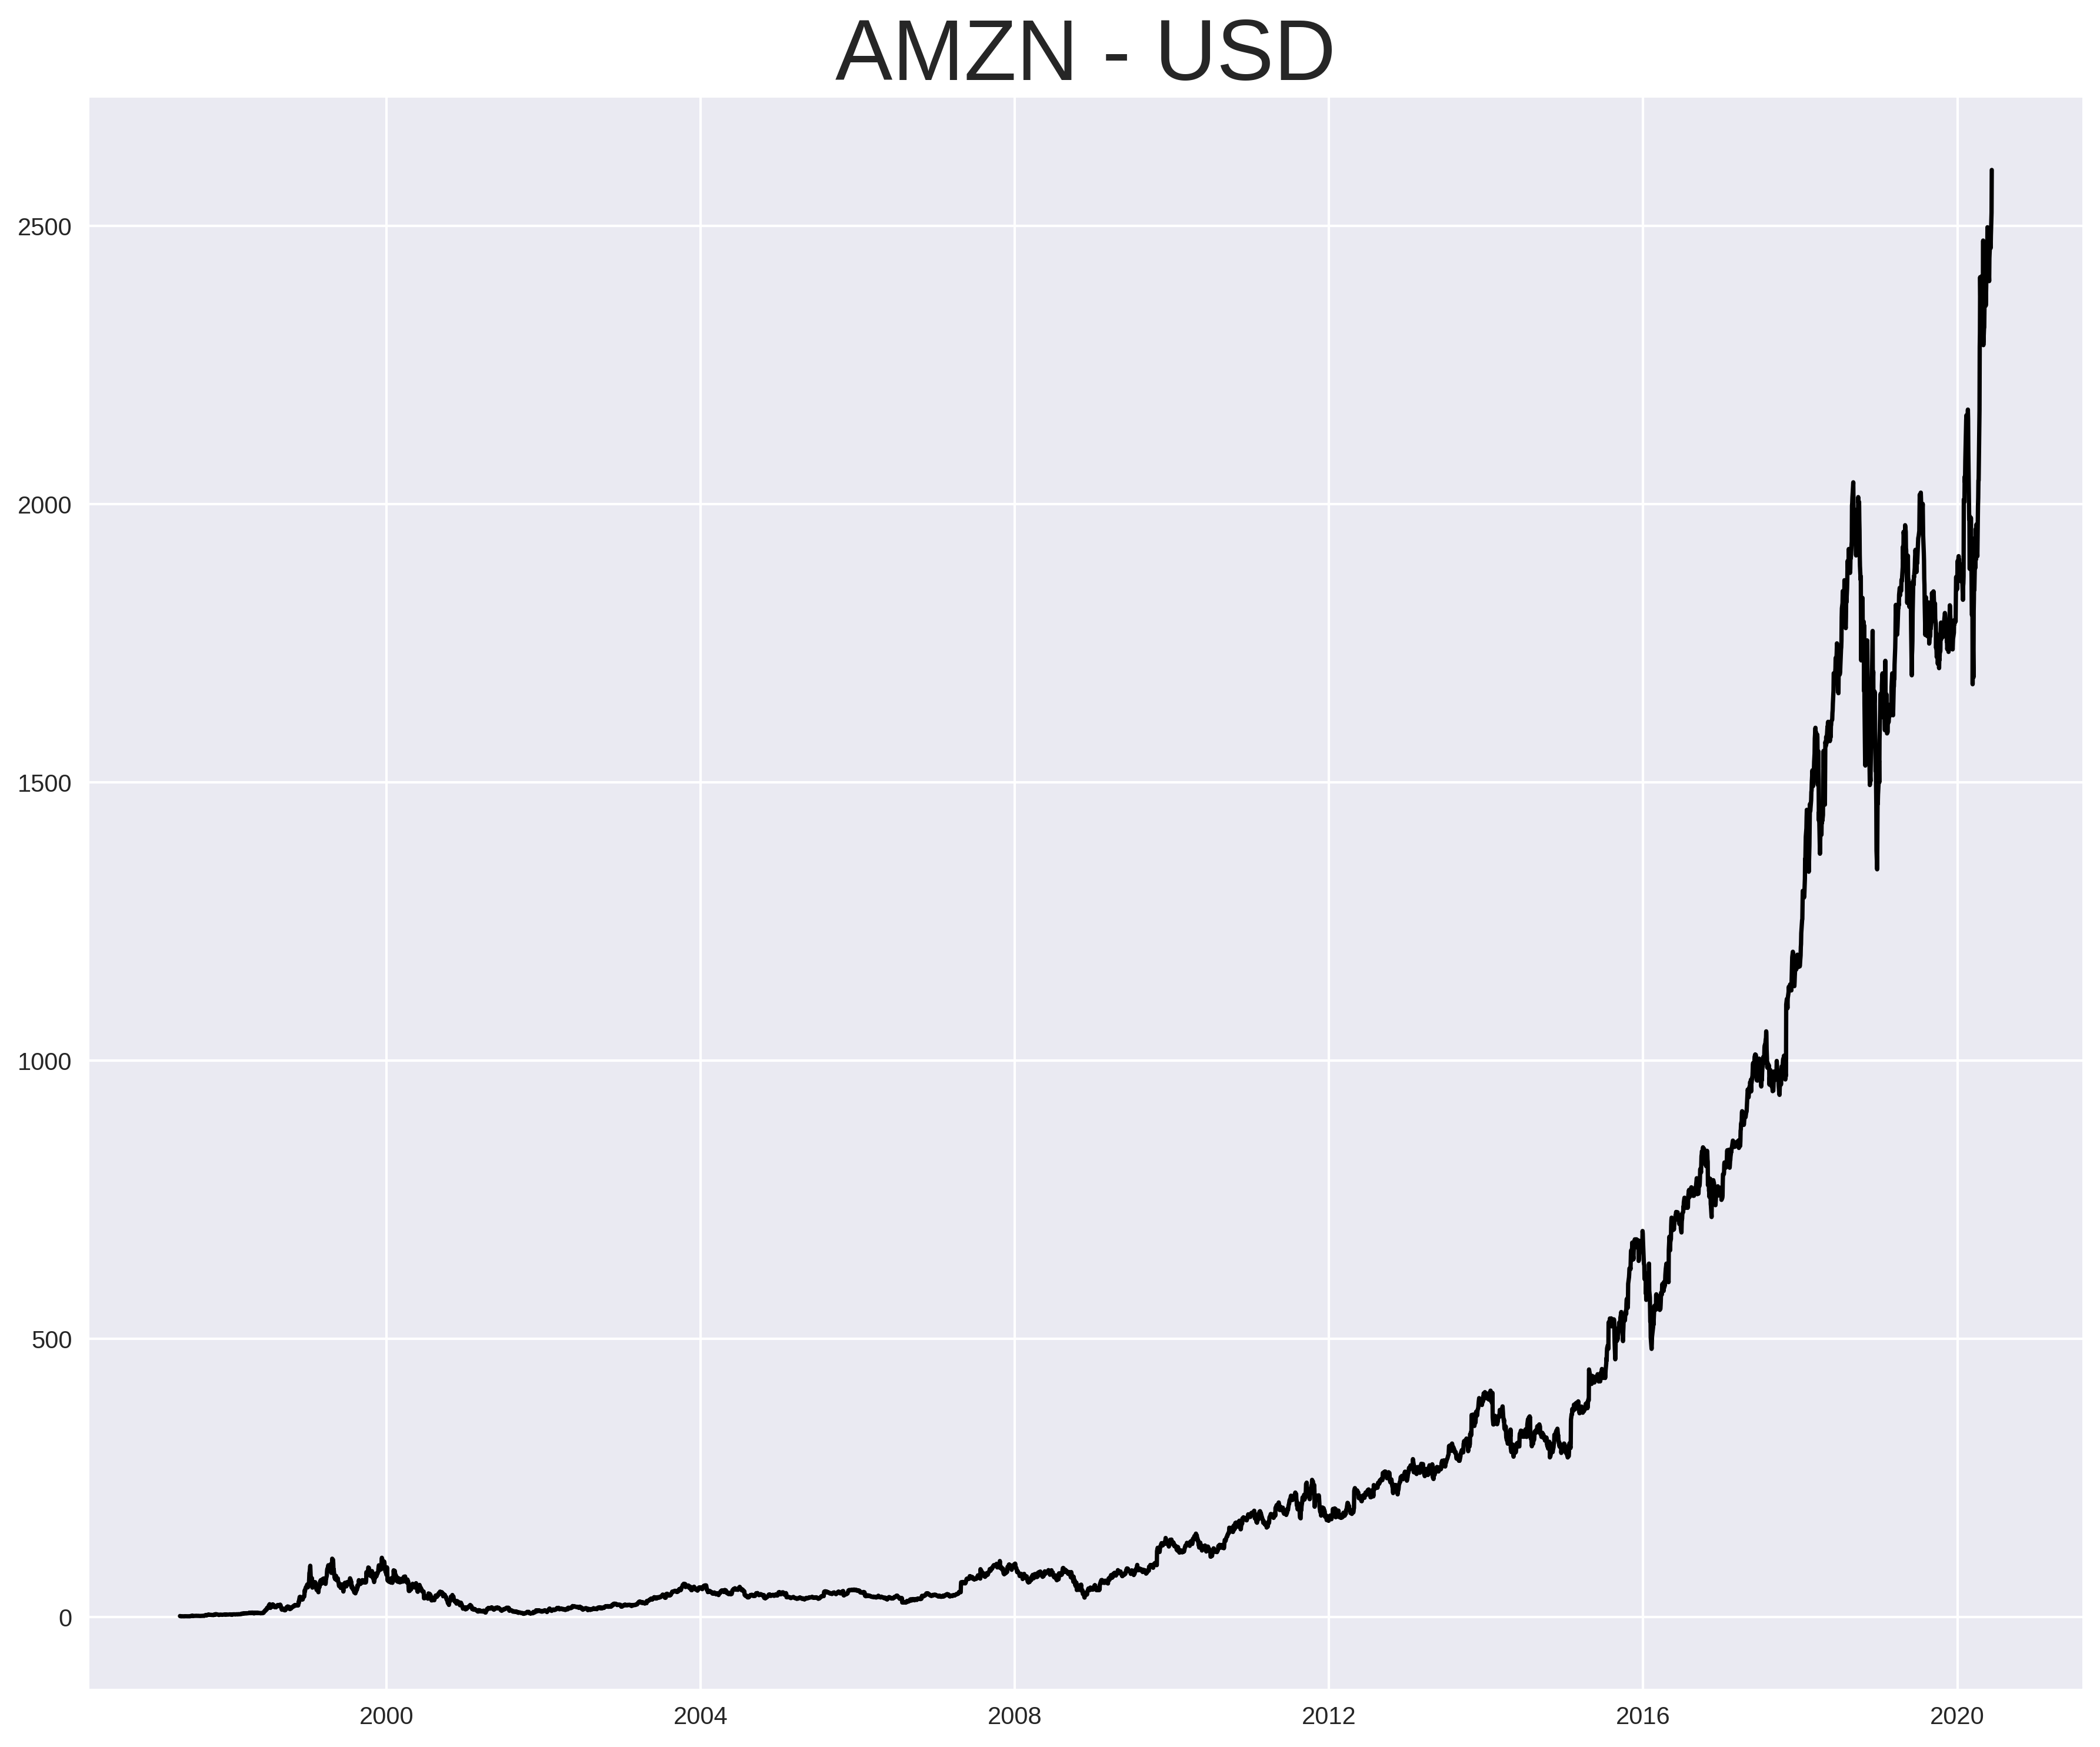

In [15]:
# Exploratory Data Analysis (EDA)
plt.figure(figsize=(12,10))
plt.plot(df['Adj Close'], color='black')
plt.title('AMZN - USD', size = 35)
plt.tight_layout()
plt.show()

In [17]:
maxvar = (max(df['Close'])-min(df['Close']))/min(df['Close'])
maxvar

1862.3027104818227

In [21]:
amzn = df.drop(['Open','High','Low','Close'], axis=1)
amzn.rename(columns={'Adj Close':'adj_close'}, inplace=True)
amzn['pct_ch'] = amzn.adj_close.pct_change()
amzn

,adj_close,Volume,pct_ch
Date,,,
1997-05-15,1.958333,72156000,NaN
1997-05-16,1.729167,14700000,-0.117021
1997-05-19,1.708333,6106800,-0.012048
1997-05-20,1.635417,5467200,-0.042683
1997-05-21,1.427083,18853200,-0.127388
...,...,...,...
2020-06-03,2478.399902,2671000,0.002423
2020-06-04,2460.600098,2948700,-0.007182
2020-06-05,2483.000000,3306400,0.009103


''

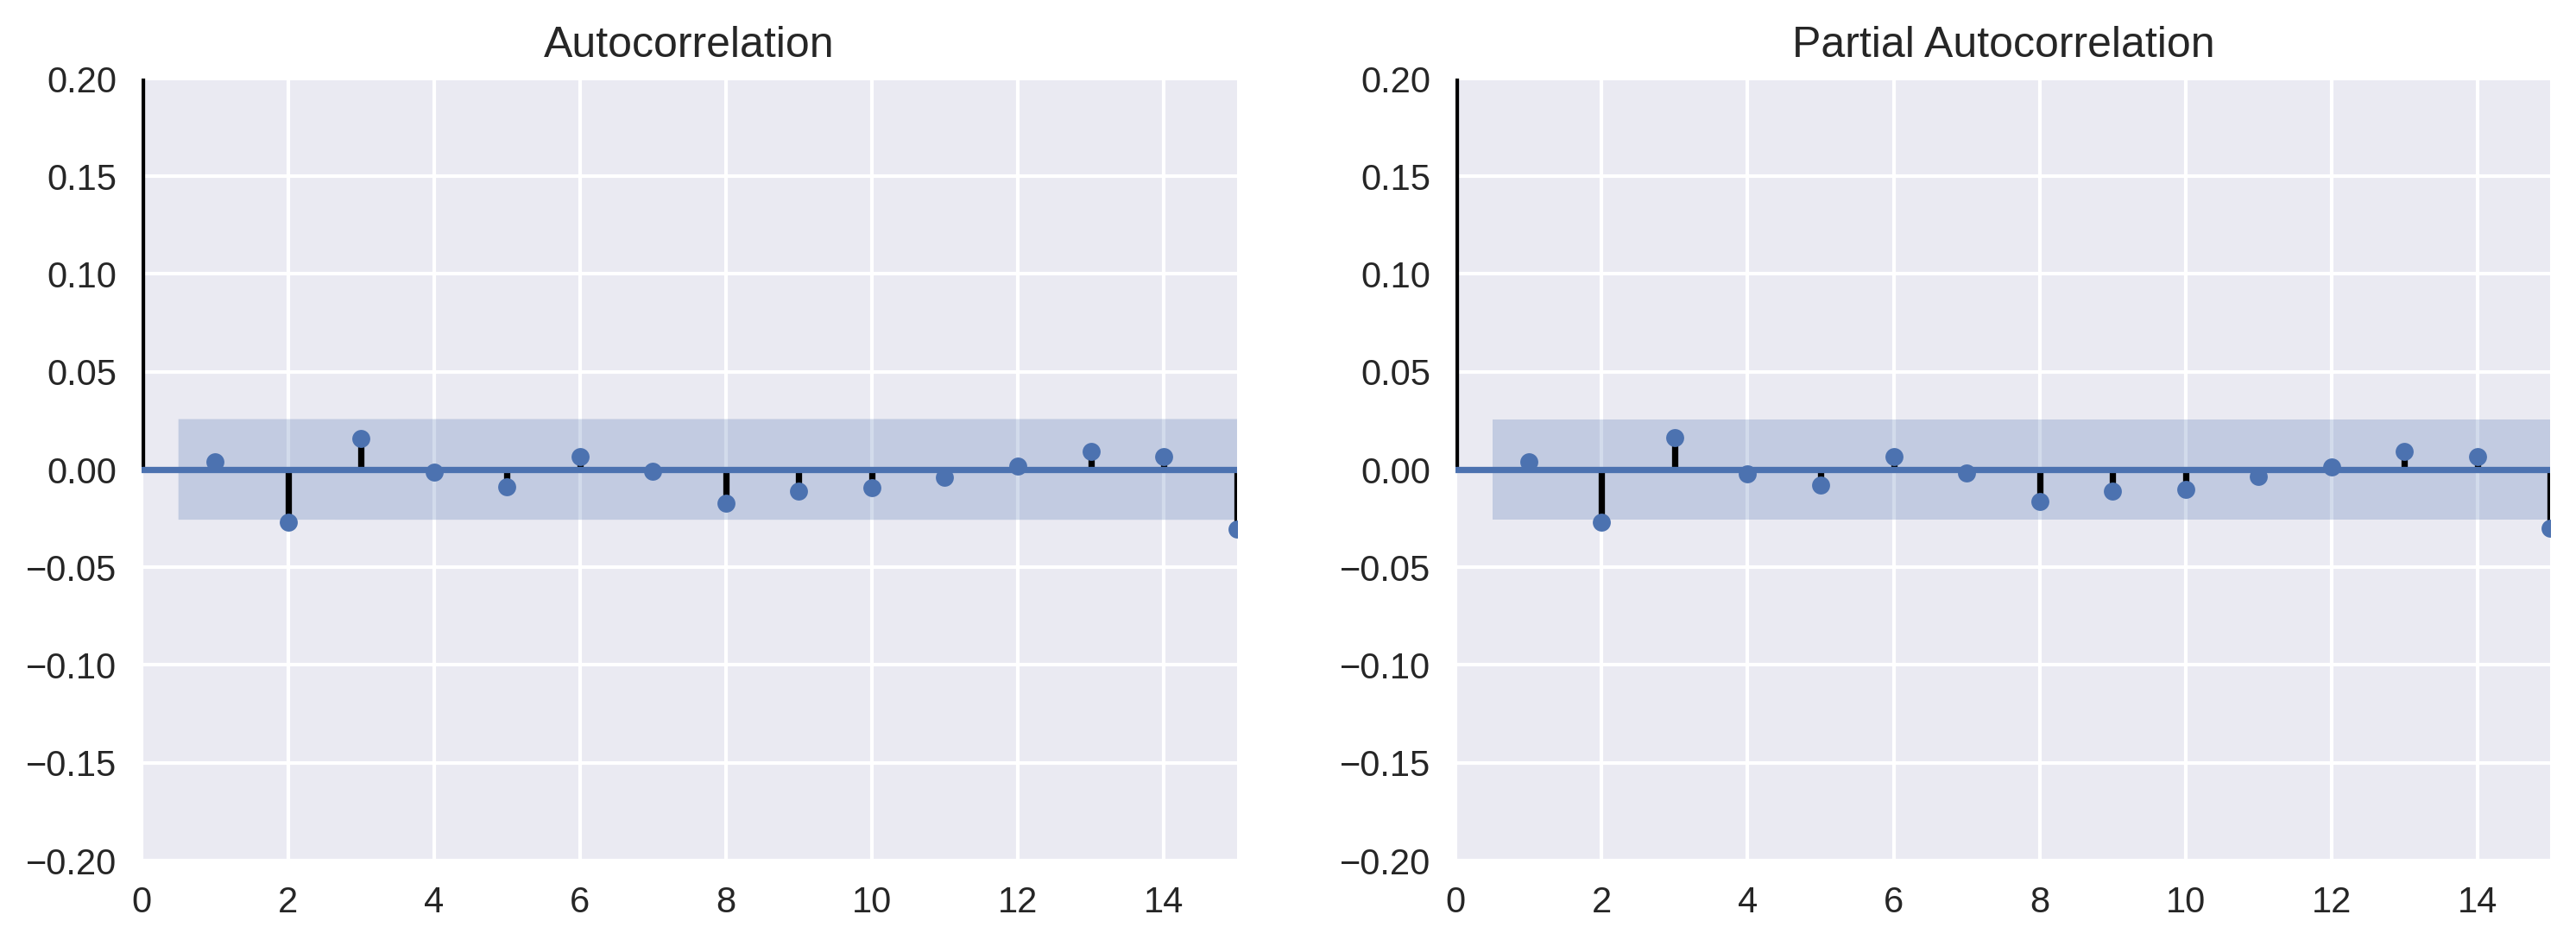

In [24]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))

# ACF chart
fig = sm.graphics.tsa.plot_acf(amzn.pct_ch.dropna(), ax=ax1)
# PACF chart
fig = sm.graphics.tsa.plot_pacf(amzn.pct_ch.dropna(), ax=ax2)

ax1.set_xlim([0,15])
ax2.set_xlim([0,15])
ax1.set_ylim([-.2,.2])
ax2.set_ylim([-.2,.2])

# Estimación DF con constante y tendencia

In [25]:
test_DF = sm.tsa.stattools.adfuller(amzn.pct_ch.dropna(), regression='ct')
print('ADF Statistic: %f' % test_DF[0])
print('p-value: %f' % test_DF[0])
print('Critical Values:')
for key, value in test_DF[4].items():
    print('\t%s: %.3f' % (key,value))
    
if test_DF[0] < test_DF[4]['5%']:
    print('Reject Ho - Time series is Stationary')
else:
    print('Failed to Reject Ho - Times series Non-Stationary')

ADF Statistic: -13.054780
p-value: -13.054780
Critical Values:
	1%: -3.960
	5%: -3.411
	10%: -3.127
Reject Ho - Time series is Stationary


# Estimación DF sin tendencia

In [26]:
test_DF = sm.tsa.stattools.adfuller(amzn.pct_ch.dropna(), regression='c')
print('ADF Statistic: %f' % test_DF[0])
print('p-value: %f' % test_DF[0])
print('Critical Values:')
for key, value in test_DF[4].items():
    print('\t%s: %.3f' % (key,value))
    
if test_DF[0] < test_DF[4]['5%']:
    print('Reject Ho - Time series is Stationary')
else:
    print('Failed to Reject Ho - Times series Non-Stationary')

ADF Statistic: -12.929361
p-value: -12.929361
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Reject Ho - Time series is Stationary


# Estimación DF sin tendencia y sin constante 

In [27]:
test_DF = sm.tsa.stattools.adfuller(amzn.pct_ch.dropna(), regression='nc')
print('ADF Statistic: %f' % test_DF[0])
print('p-value: %f' % test_DF[0])
print('Critical Values:')
for key, value in test_DF[4].items():
    print('\t%s: %.3f' % (key,value))
    
if test_DF[0] < test_DF[4]['5%']:
    print('Reject Ho - Time series is Stationary')
else:
    print('Failed to Reject Ho - Times series Non-Stationary')

ADF Statistic: -12.324653
p-value: -12.324653
Critical Values:
	1%: -2.566
	5%: -1.941
	10%: -1.617
Reject Ho - Time series is Stationary


In [11]:
# encontramos problema de raíz unitaria
# este problema se encuentra cuando haces el test DF
# al precio y no a los retornos

# Una vez encontrado el problema de raíz unitario
# procedemos a solucionarlo con diferencias

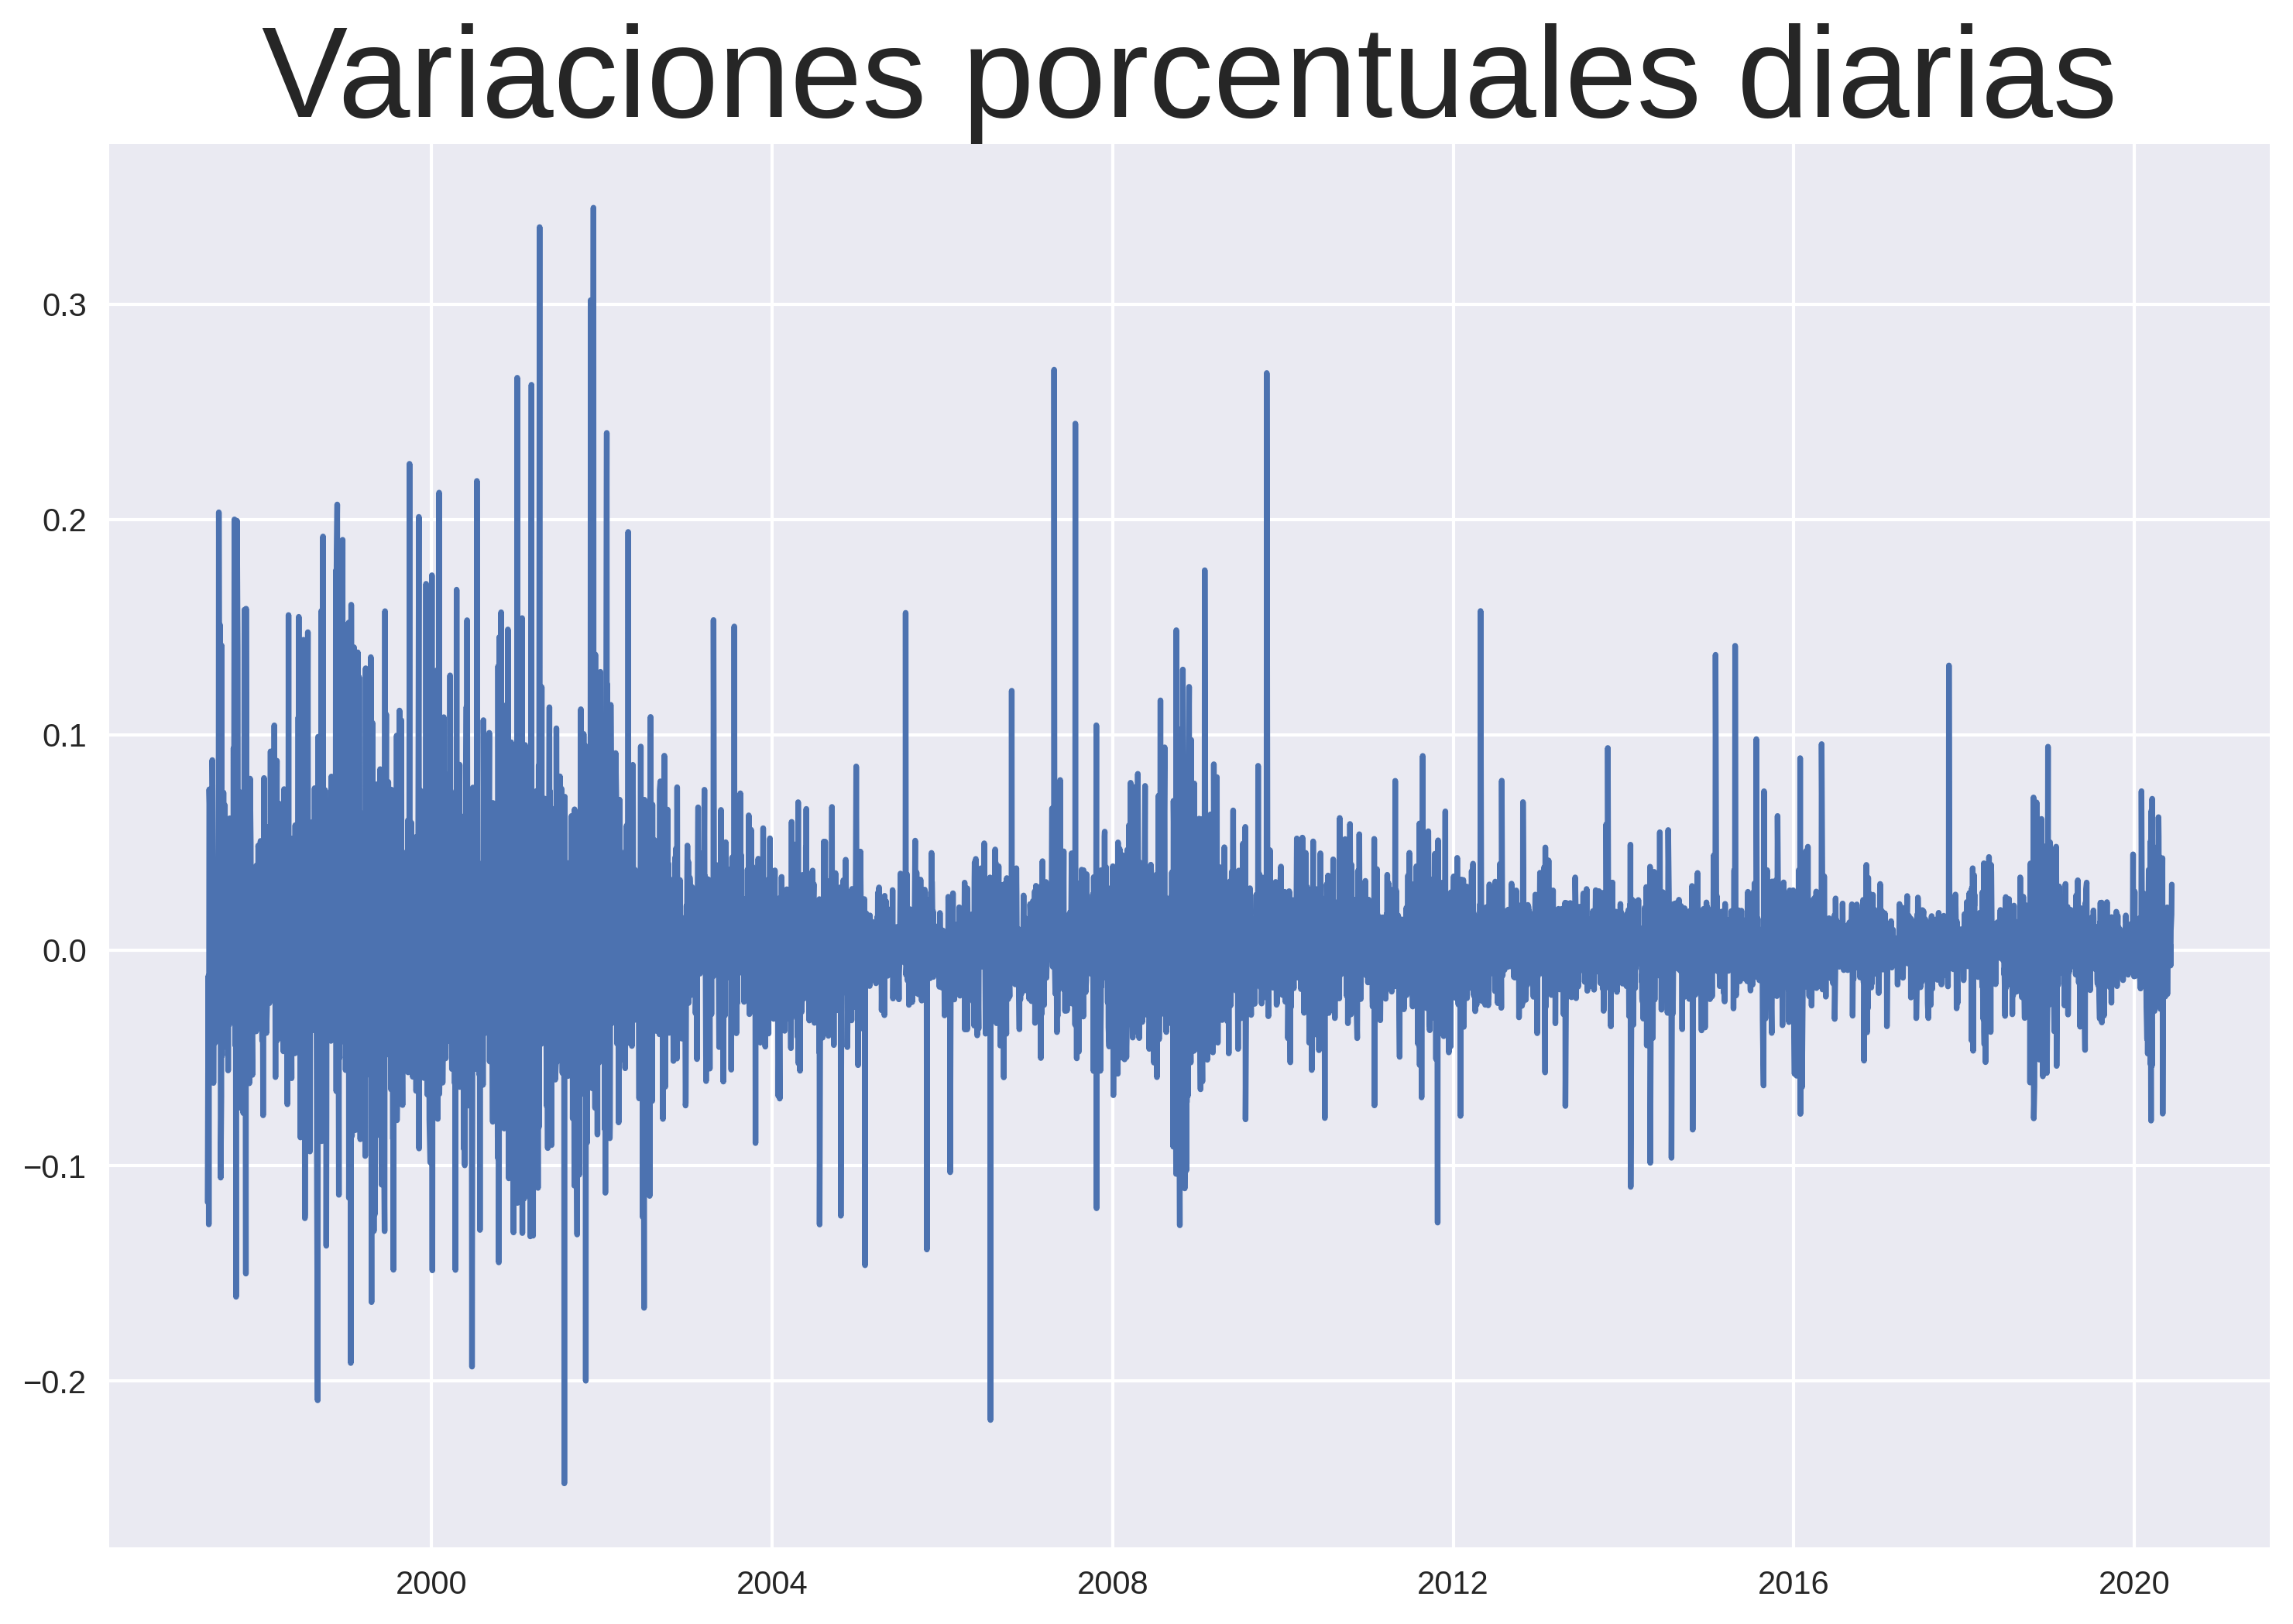

In [28]:
plt.figure(figsize=(12,8))
plt.title('Variaciones porcentuales diarias', size=40)
plt.plot(amzn.pct_ch);

# Se concluye desde un inicio que es estacionario, por lo tanto se procede a evaluar el modelo la FAS y FAP

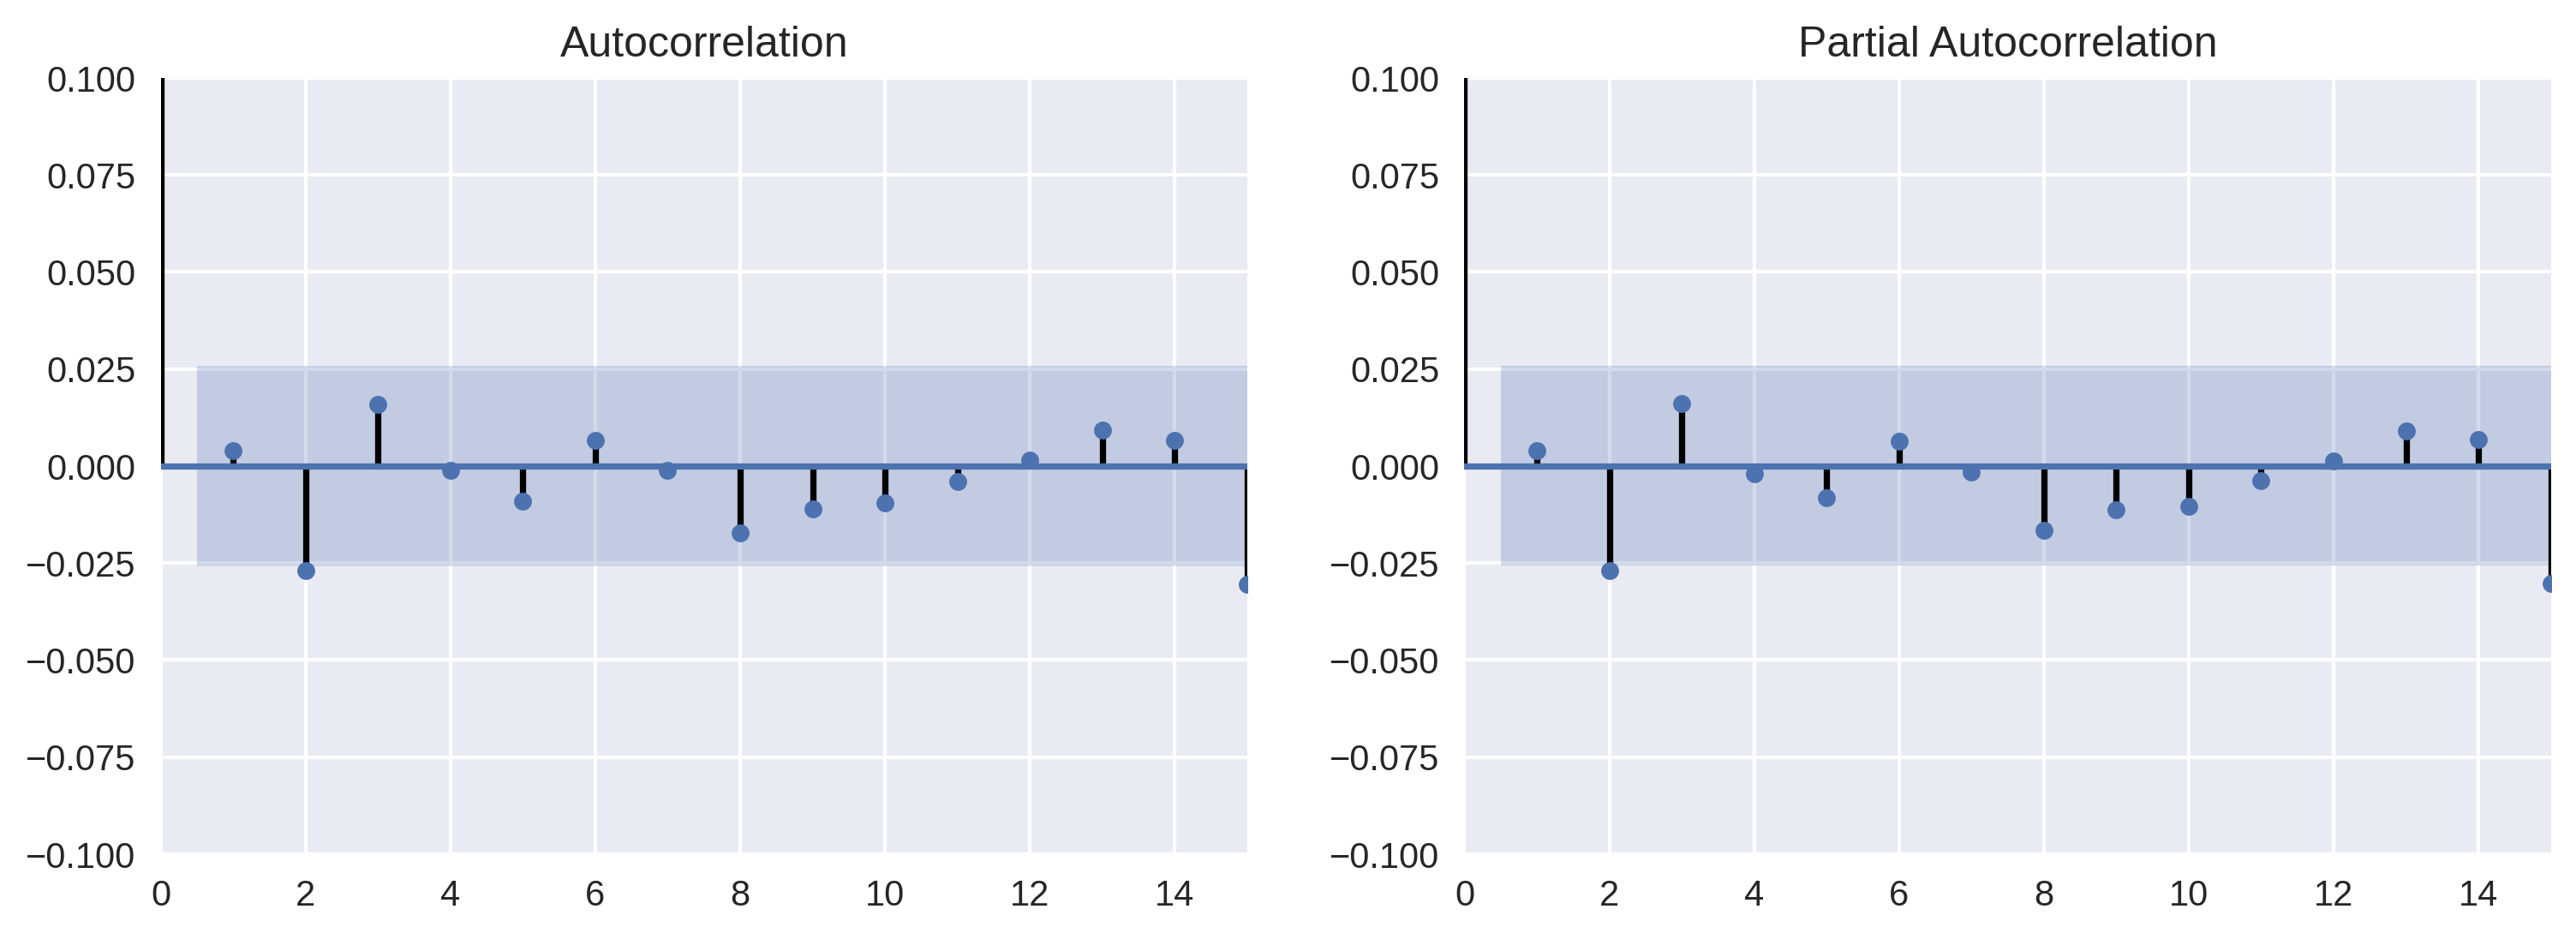

In [29]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
ax1.set_xlim([0,15])
ax2.set_xlim([0,15])
ax1.set_ylim([-.1,.1])
ax2.set_ylim([-.1,.1])
# ACF chart
fig = sm.graphics.tsa.plot_acf(amzn.pct_ch.dropna(), ax=ax1)
# PACF chart
fig = sm.graphics.tsa.plot_pacf(amzn.pct_ch.dropna(), ax=ax2)
# ignorar el primero

In [31]:
# usaremos la librería pmdarima para tener el mejor modelo
# ARIMA
import pmdarima as pm

In [39]:
model = pm.auto_arima(amzn.adj_close,
                     error_action='ignore',
                     suppress_warnings=True,
                     seasonal=False,
                     stepwise=False,
                     approximation=False,
                     n_jobs=1)

In [40]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5805
Model:               SARIMAX(2, 2, 3)   Log Likelihood              -22981.281
Date:                Tue, 09 Jun 2020   AIC                          45976.563
Time:                        15:52:30   BIC                          46023.225
Sample:                             0   HQIC                         45992.794
                               - 5805                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0012      0.000      3.909      0.000       0.001       0.002
ar.L1         -1.7046      0.008   -224.017      0.000      -1.720      -1.690
ar.L2         -0.8804      0.008   -110.713      0.000      -0.896      -0.865
ma.L1          0.6427      0.009     71.097      0.000       0.625       0.660
ma.L2         -0.8327      0.004   -229.657      0.000      -0.840      -0.826
ma.L3         -0.8088      0.010    -81.920      0.000      -0.828      -0.789
sigma2       160.9944      0.707    227.686      0.000     159.608     162.380
===================================================================================
Ljung-Box (Q):                      256.20   Jarque-Bera (JB):            401908.36
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):             100.50   Skew:                            -0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                        43.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [50]:
arima = ARIMA(amzn.adj_close, order=(2, 2, 3)).fit(disp=0)
arima.summary()

/home/alvin/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/alvin/.local/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:216: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/alvin/.local/lib/python3.8/site-packages/statsmodels/base/model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warn('Inverting hessian failed, no bse or cov_params '


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:           D2.adj_close   No. Observations:                 5803
Model:                 ARIMA(2, 2, 3)   Log Likelihood              -22980.695
Method:                       css-mle   S.D. of innovations             12.685
Date:                Tue, 09 Jun 2020   AIC                          45975.389
Time:                        16:01:23   BIC                          46022.052
Sample:                             2   HQIC                         45991.621
                                                                              
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0003   9.55e-05      3.522      0.000       0.000       0.001
ar.L1.D2.adj_close    -1.6928      0.025    -66.990      0.000      -1.742      -1.643
ar.L2.D2.adj_close    -0.8349      0.029    -29.198      0.000      -0.891      -0.779
ma.L1.D2.adj_close     0.6318      0.030     21.309      0.000       0.574       0.690
ma.L2.D2.adj_close    -0.8751      0.020    -43.702      0.000      -0.914      -0.836
ma.L3.D2.adj_close    -0.7566      0.032    -23.465      0.000      -0.820      -0.693
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0138           -0.4123j            1.0944           -0.4385
AR.2           -1.0138           +0.4123j            1.0944            0.4385
MA.1            1.0000           -0.0000j            1.0000           -0.0000
MA.2           -1.0783           -0.3986j            1.1496           -0.4436
MA.3           -1.0783           +0.3986j            1.1496            0.4436
-----------------------------------------------------------------------------
"""

## Diagnóstico del modelo

In [41]:
def arima_diagnostics(resids, n_lags=40):
    '''
    Function for diagnosing the fit of an ARIMA model by investigating the residuals.
    
    Parameters
    ----------
    resids : np.array
        An array containing the residuals of a fitted model
    n_lags : int
        Number of lags for autocorrelation plot
        
    Returns
    -------
    fig : matplotlib.figure.Figure
        Created figure
    '''
     
    # create placeholder subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

    r = resids
    resids = (r - np.nanmean(r)) / np.nanstd(r)
    resids_nonmissing = resids[~(np.isnan(resids))]
    
    # residuals over time
    sns.lineplot(x=np.arange(len(resids)), y=resids, ax=ax1)
    ax1.set_title('Standardized residuals')

    # distribution of residuals
    x_lim = (-1.96 * 2, 1.96 * 2)
    r_range = np.linspace(x_lim[0], x_lim[1])
    norm_pdf = scs.norm.pdf(r_range)
    
    sns.distplot(resids_nonmissing, hist=True, kde=True, 
                 norm_hist=True, ax=ax2)
    ax2.plot(r_range, norm_pdf, 'g', lw=2, label='N(0,1)')
    ax2.set_title('Distribution of standardized residuals')
    ax2.set_xlim(x_lim)
    ax2.legend()
        
    # Q-Q plot
    qq = sm.qqplot(resids_nonmissing, line='s', ax=ax3)
    ax3.set_title('Q-Q plot')

    # ACF plot
    plot_acf(resids, ax=ax4, lags=n_lags, alpha=0.05)
    ax4.set_title('ACF plot')

    return fig

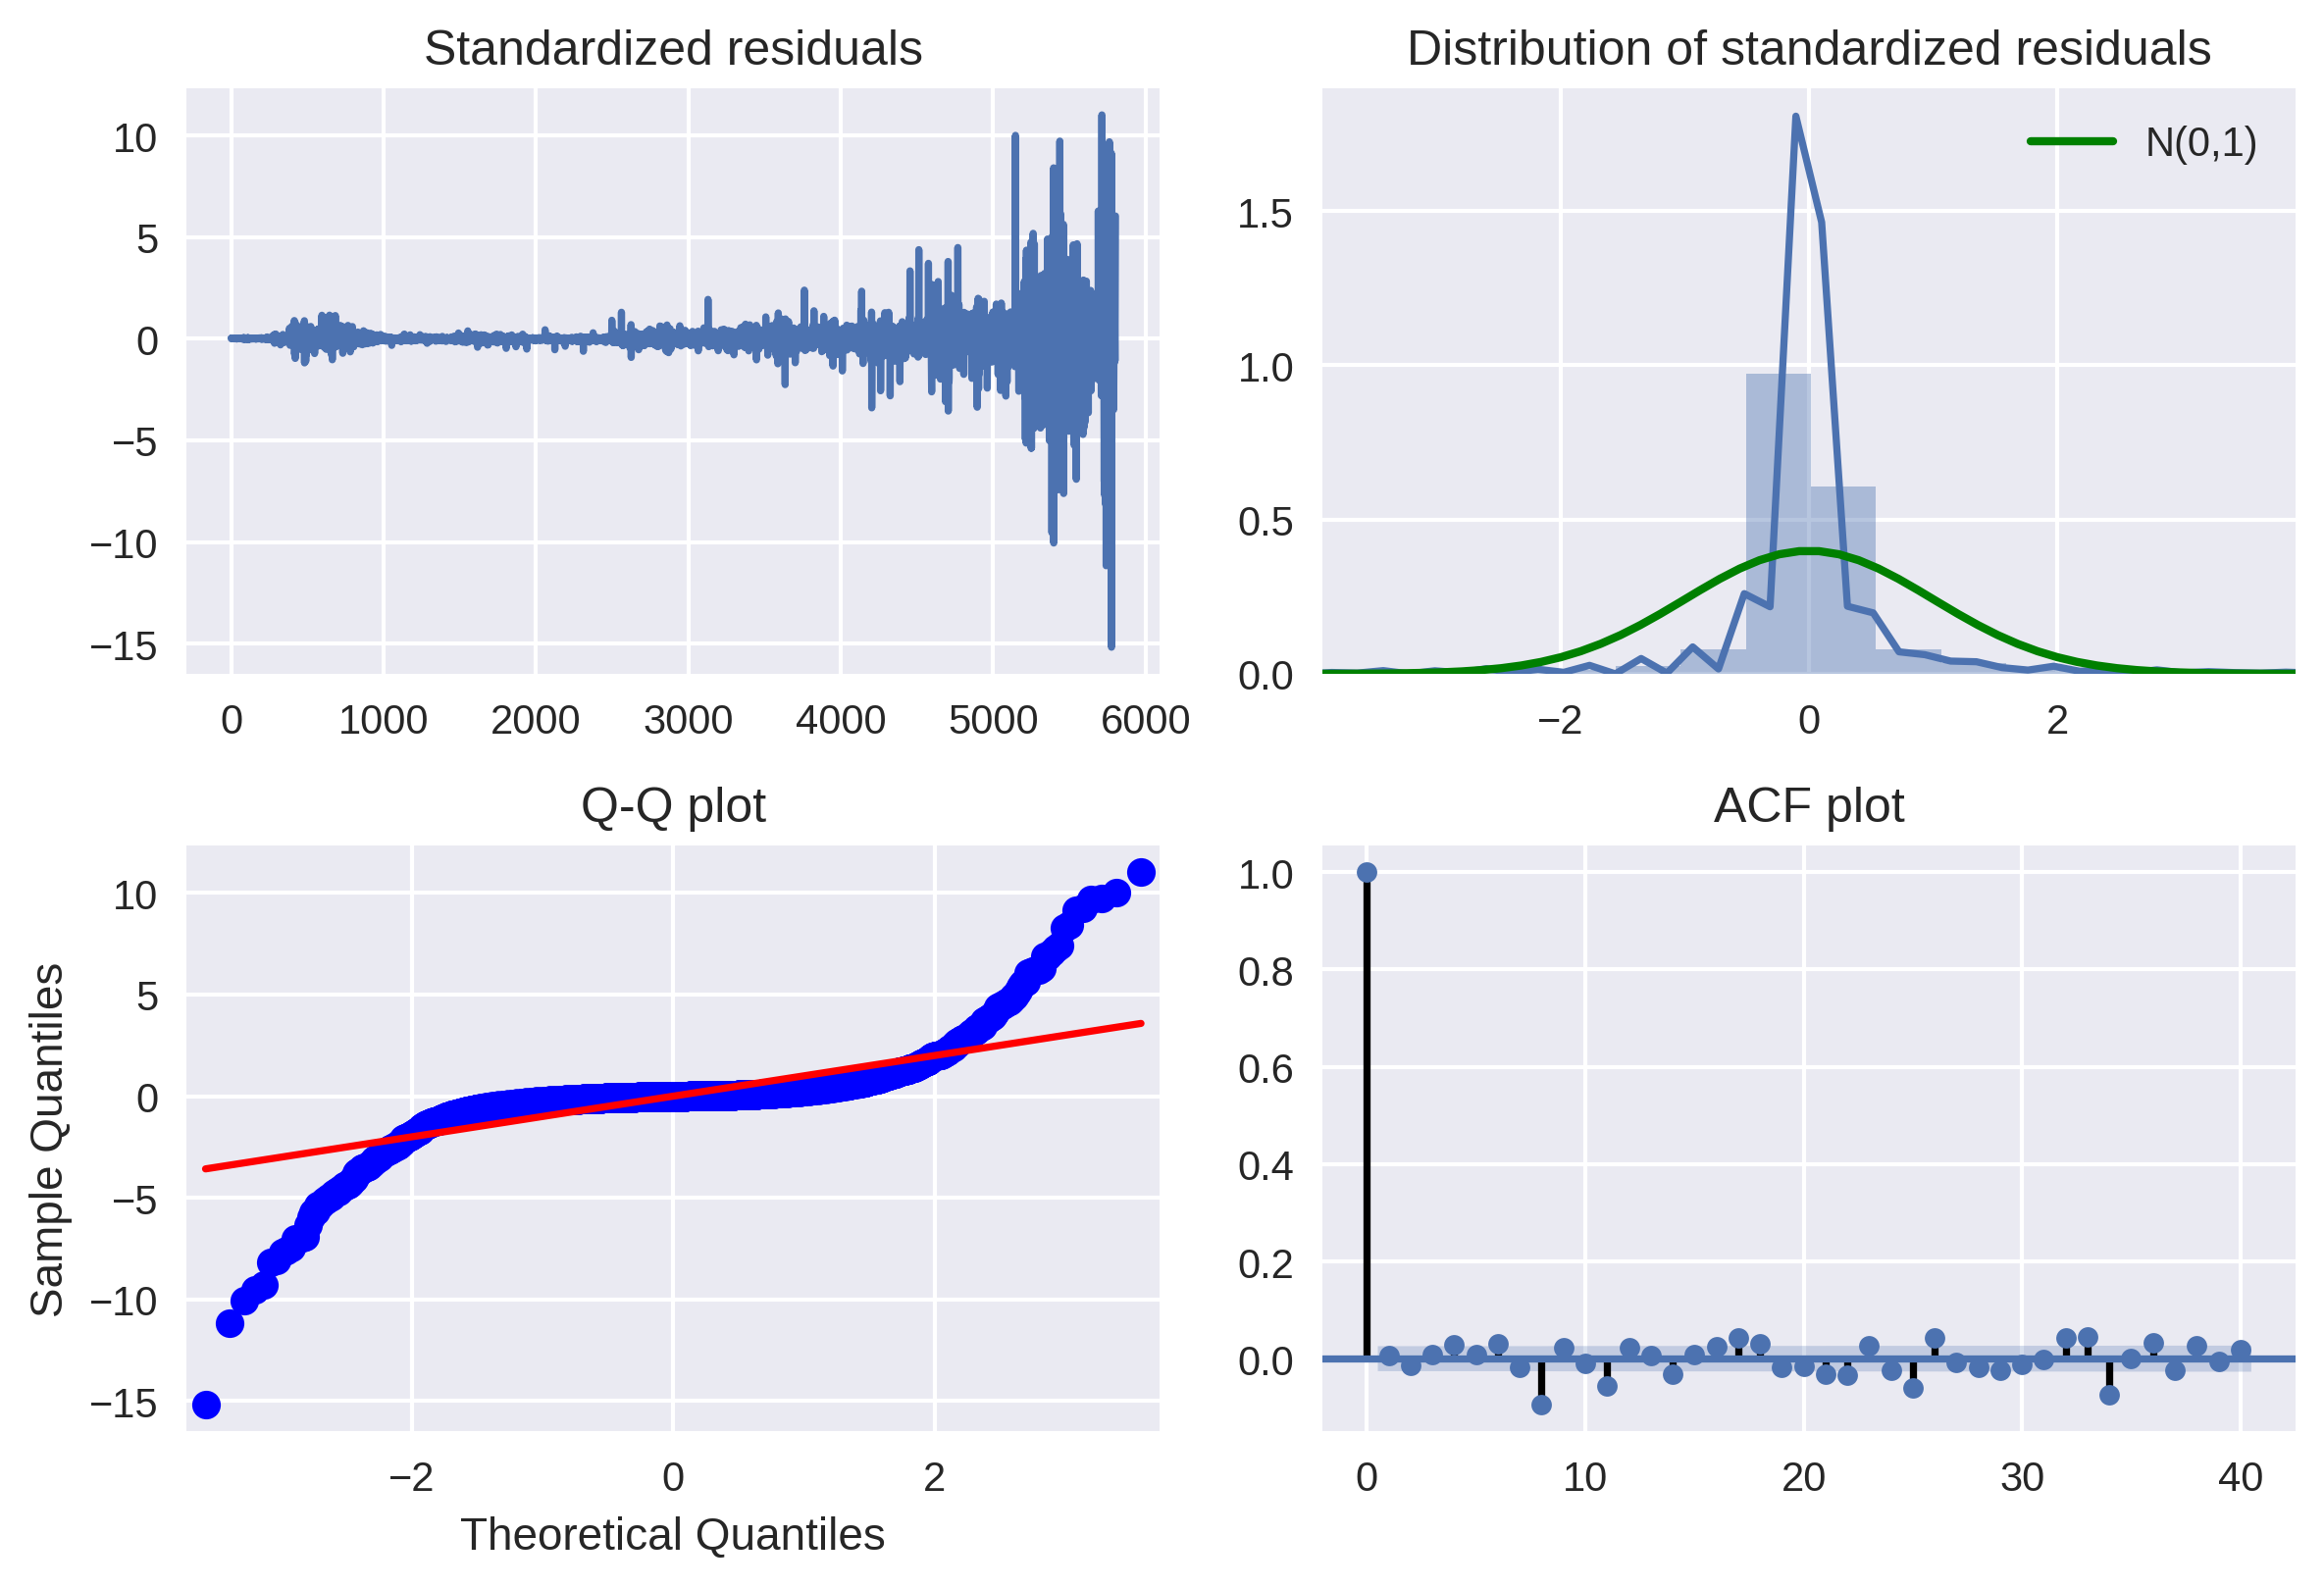

In [57]:
arima_diagnostics(arima.resid, 40)

plt.tight_layout()
plt.show()

In [59]:
from statsmodels.stats.diagnostic import acorr_ljungbox


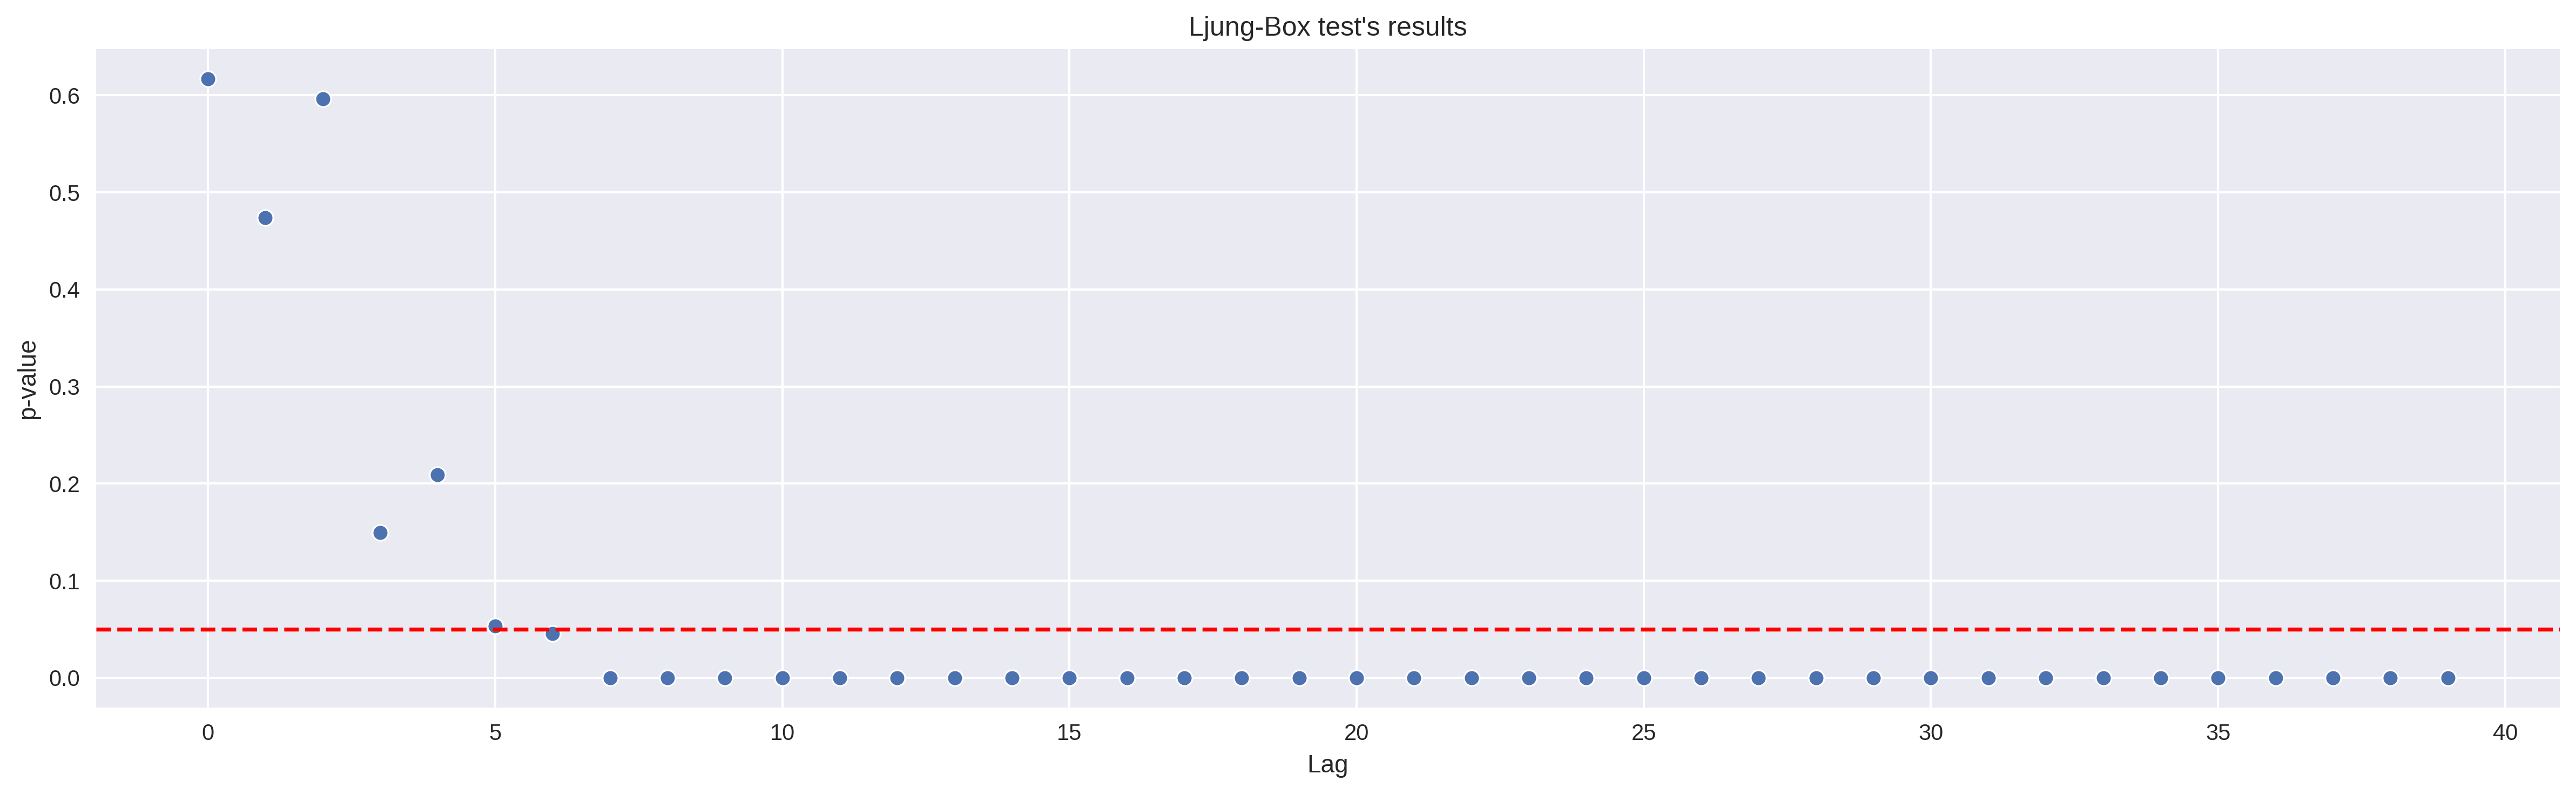

In [60]:
ljung_box_results = acorr_ljungbox(arima.resid)

fig, ax = plt.subplots(1, figsize=[16, 5])
sns.scatterplot(x=range(len(ljung_box_results[1])), 
                y=ljung_box_results[1], 
                ax=ax)
ax.axhline(0.05, ls='--', c='r')
ax.set(title="Ljung-Box test's results",
       xlabel='Lag',
       ylabel='p-value')

plt.tight_layout()
plt.show()

In [48]:
df = yf.download('AMZN',
                 start='2020-01-01',
                 adjusted=True,
                 progress=False)

print(f'Downloaded {df.shape[0]} rows of data.')

test = df.rename(columns={'Adj Close': 'adj_close'}) \
         .adj_close 

Downloaded 110 rows of data.


In [77]:
n_forecasts = len(test)

arima_pred = arima.forecast(n_forecasts)

arima_pred = [pd.DataFrame(arima_pred[0], columns=['prediction']),
              pd.DataFrame(arima_pred[2], columns=['ci_lower', 
                                                   'ci_upper'])]
arima_pred = pd.concat(arima_pred, axis=1).set_index(test.index)

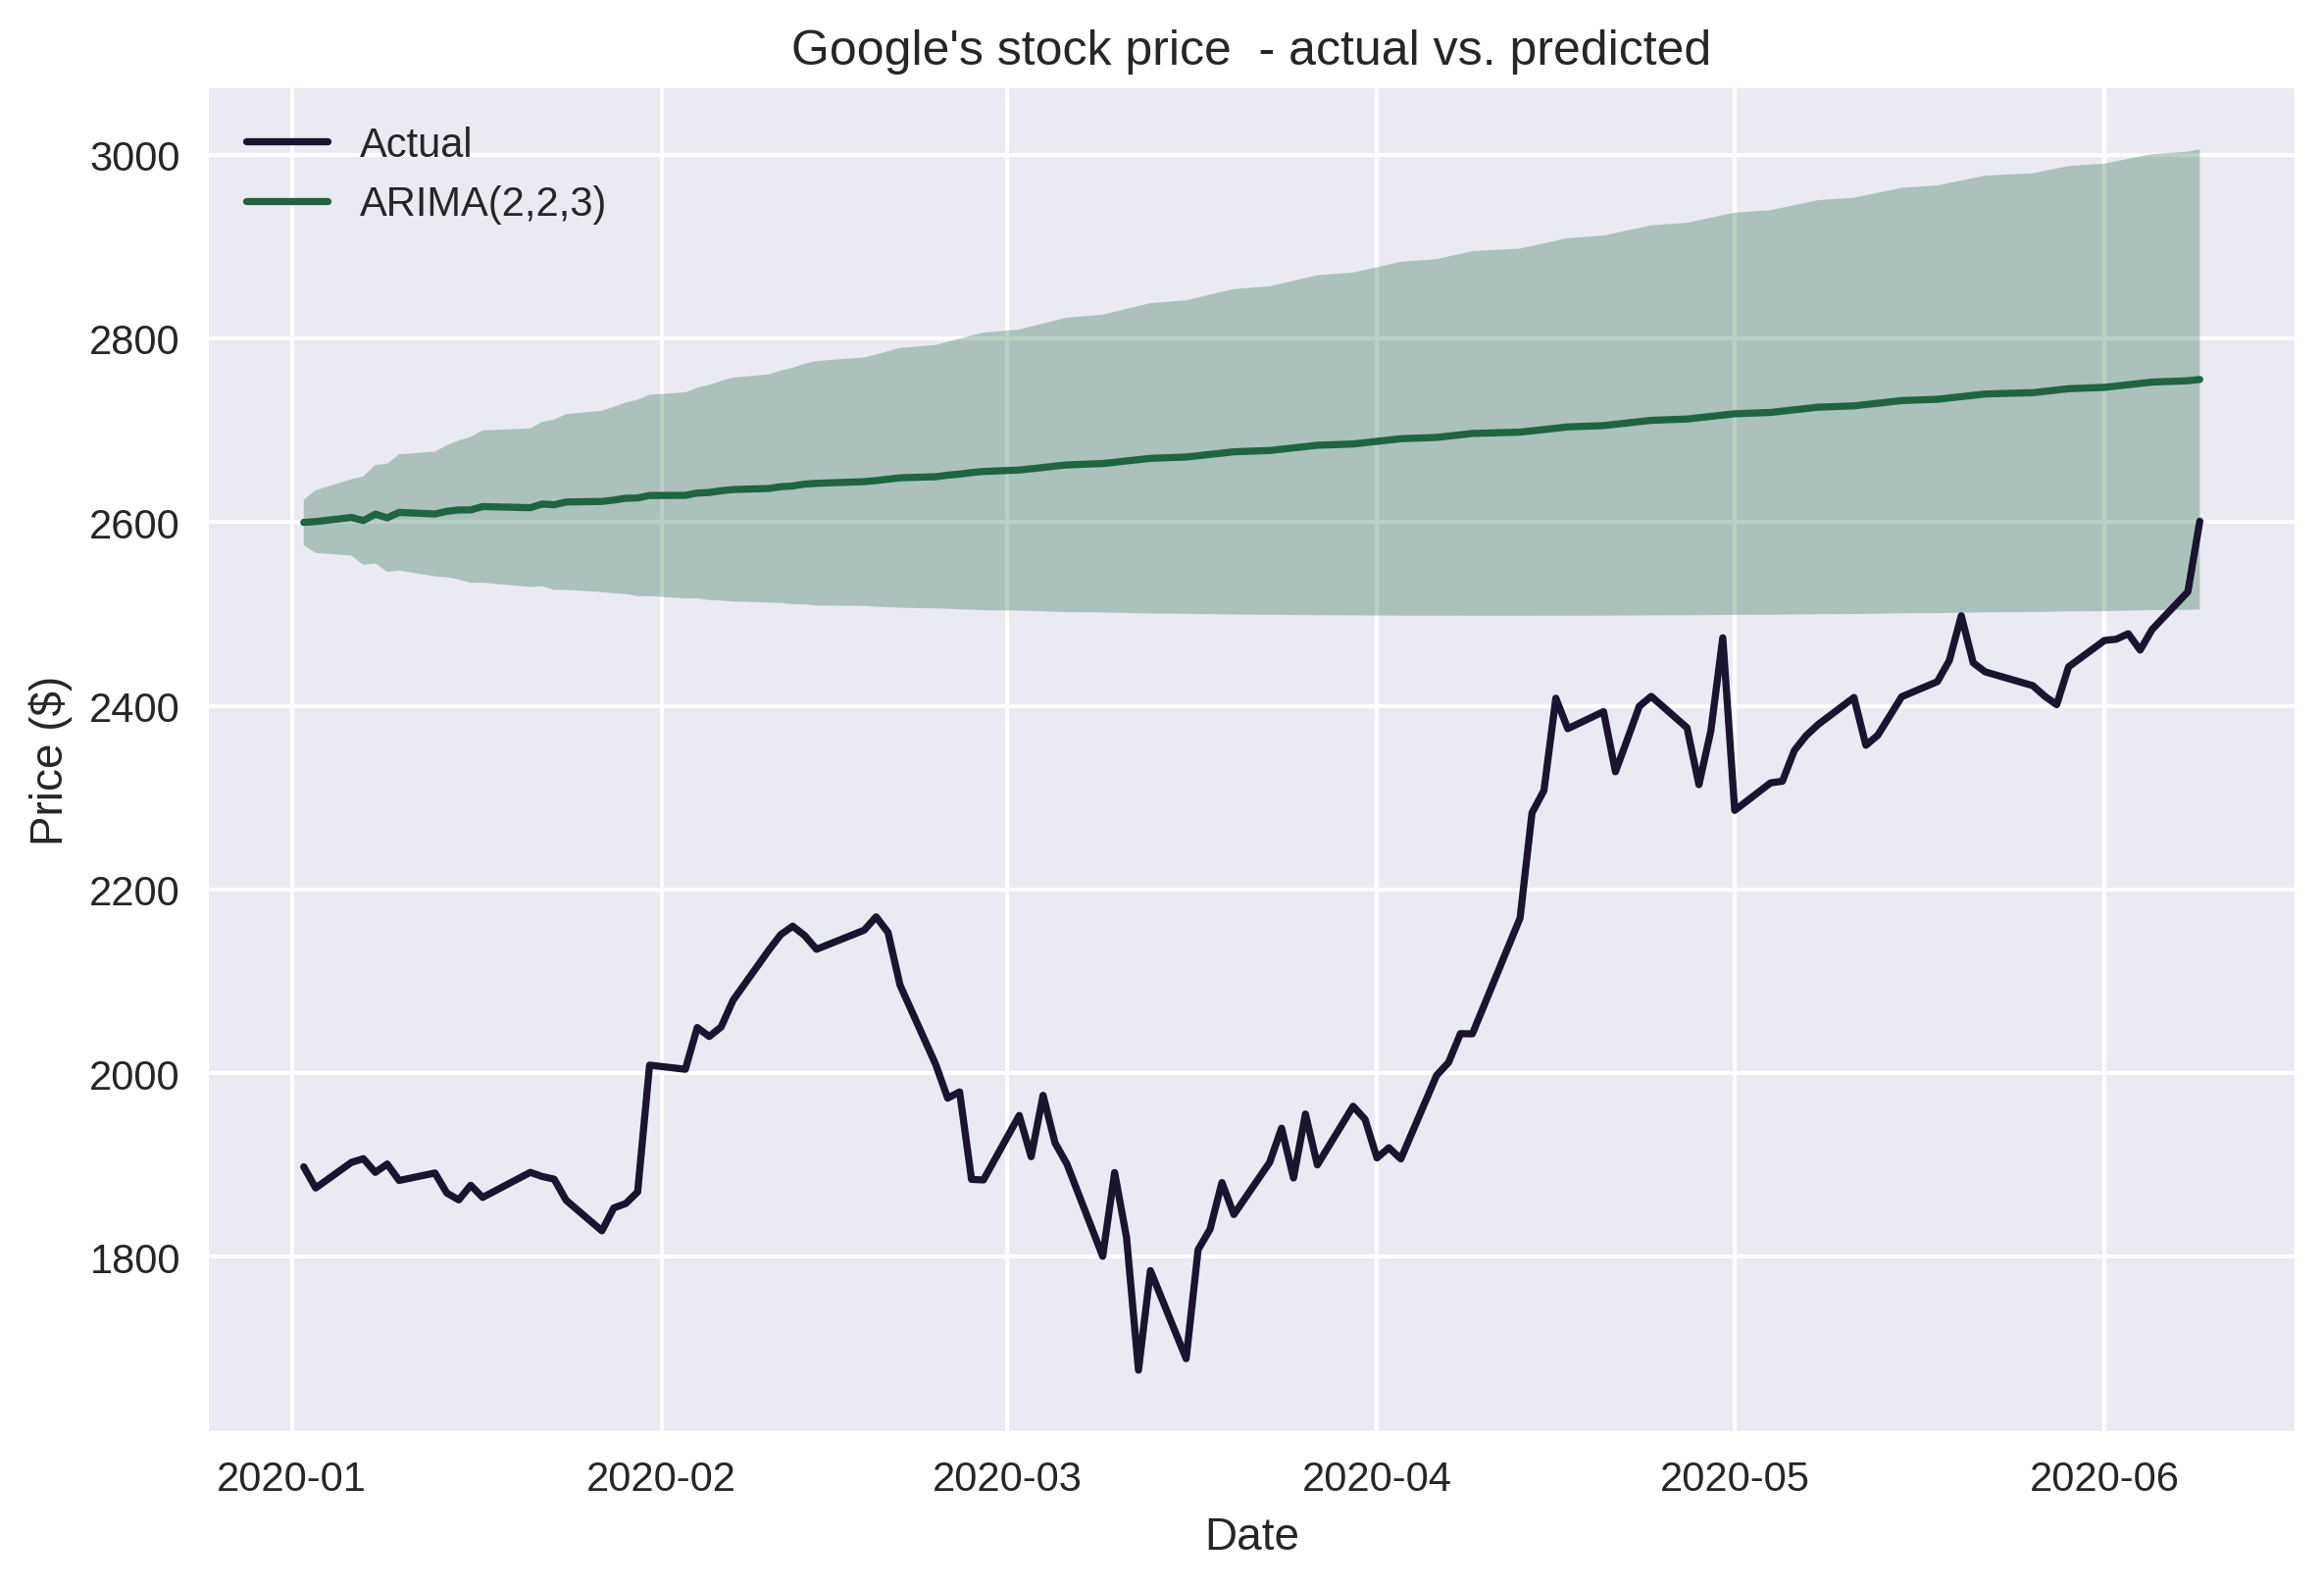

In [78]:
fig, ax = plt.subplots(1)

ax = sns.lineplot(data=test, color=COLORS[0], label='Actual')

ax.plot(arima_pred.prediction, c=COLORS[1], label='ARIMA(2,2,3)')
ax.fill_between(arima_pred.index,
                arima_pred.ci_lower,
                arima_pred.ci_upper,
                alpha=0.3, 
                facecolor=COLORS[1])



ax.set(title="Amazon's stock price  - actual vs. predicted", 
       xlabel='Date', 
       ylabel='Price ($)')
ax.legend(loc='upper left')

plt.tight_layout()
plt.show()

## ARCH models

In [81]:

from arch import arch_model

In [86]:
returns = 100 * amzn.pct_ch.dropna()

Average return: 0.19%


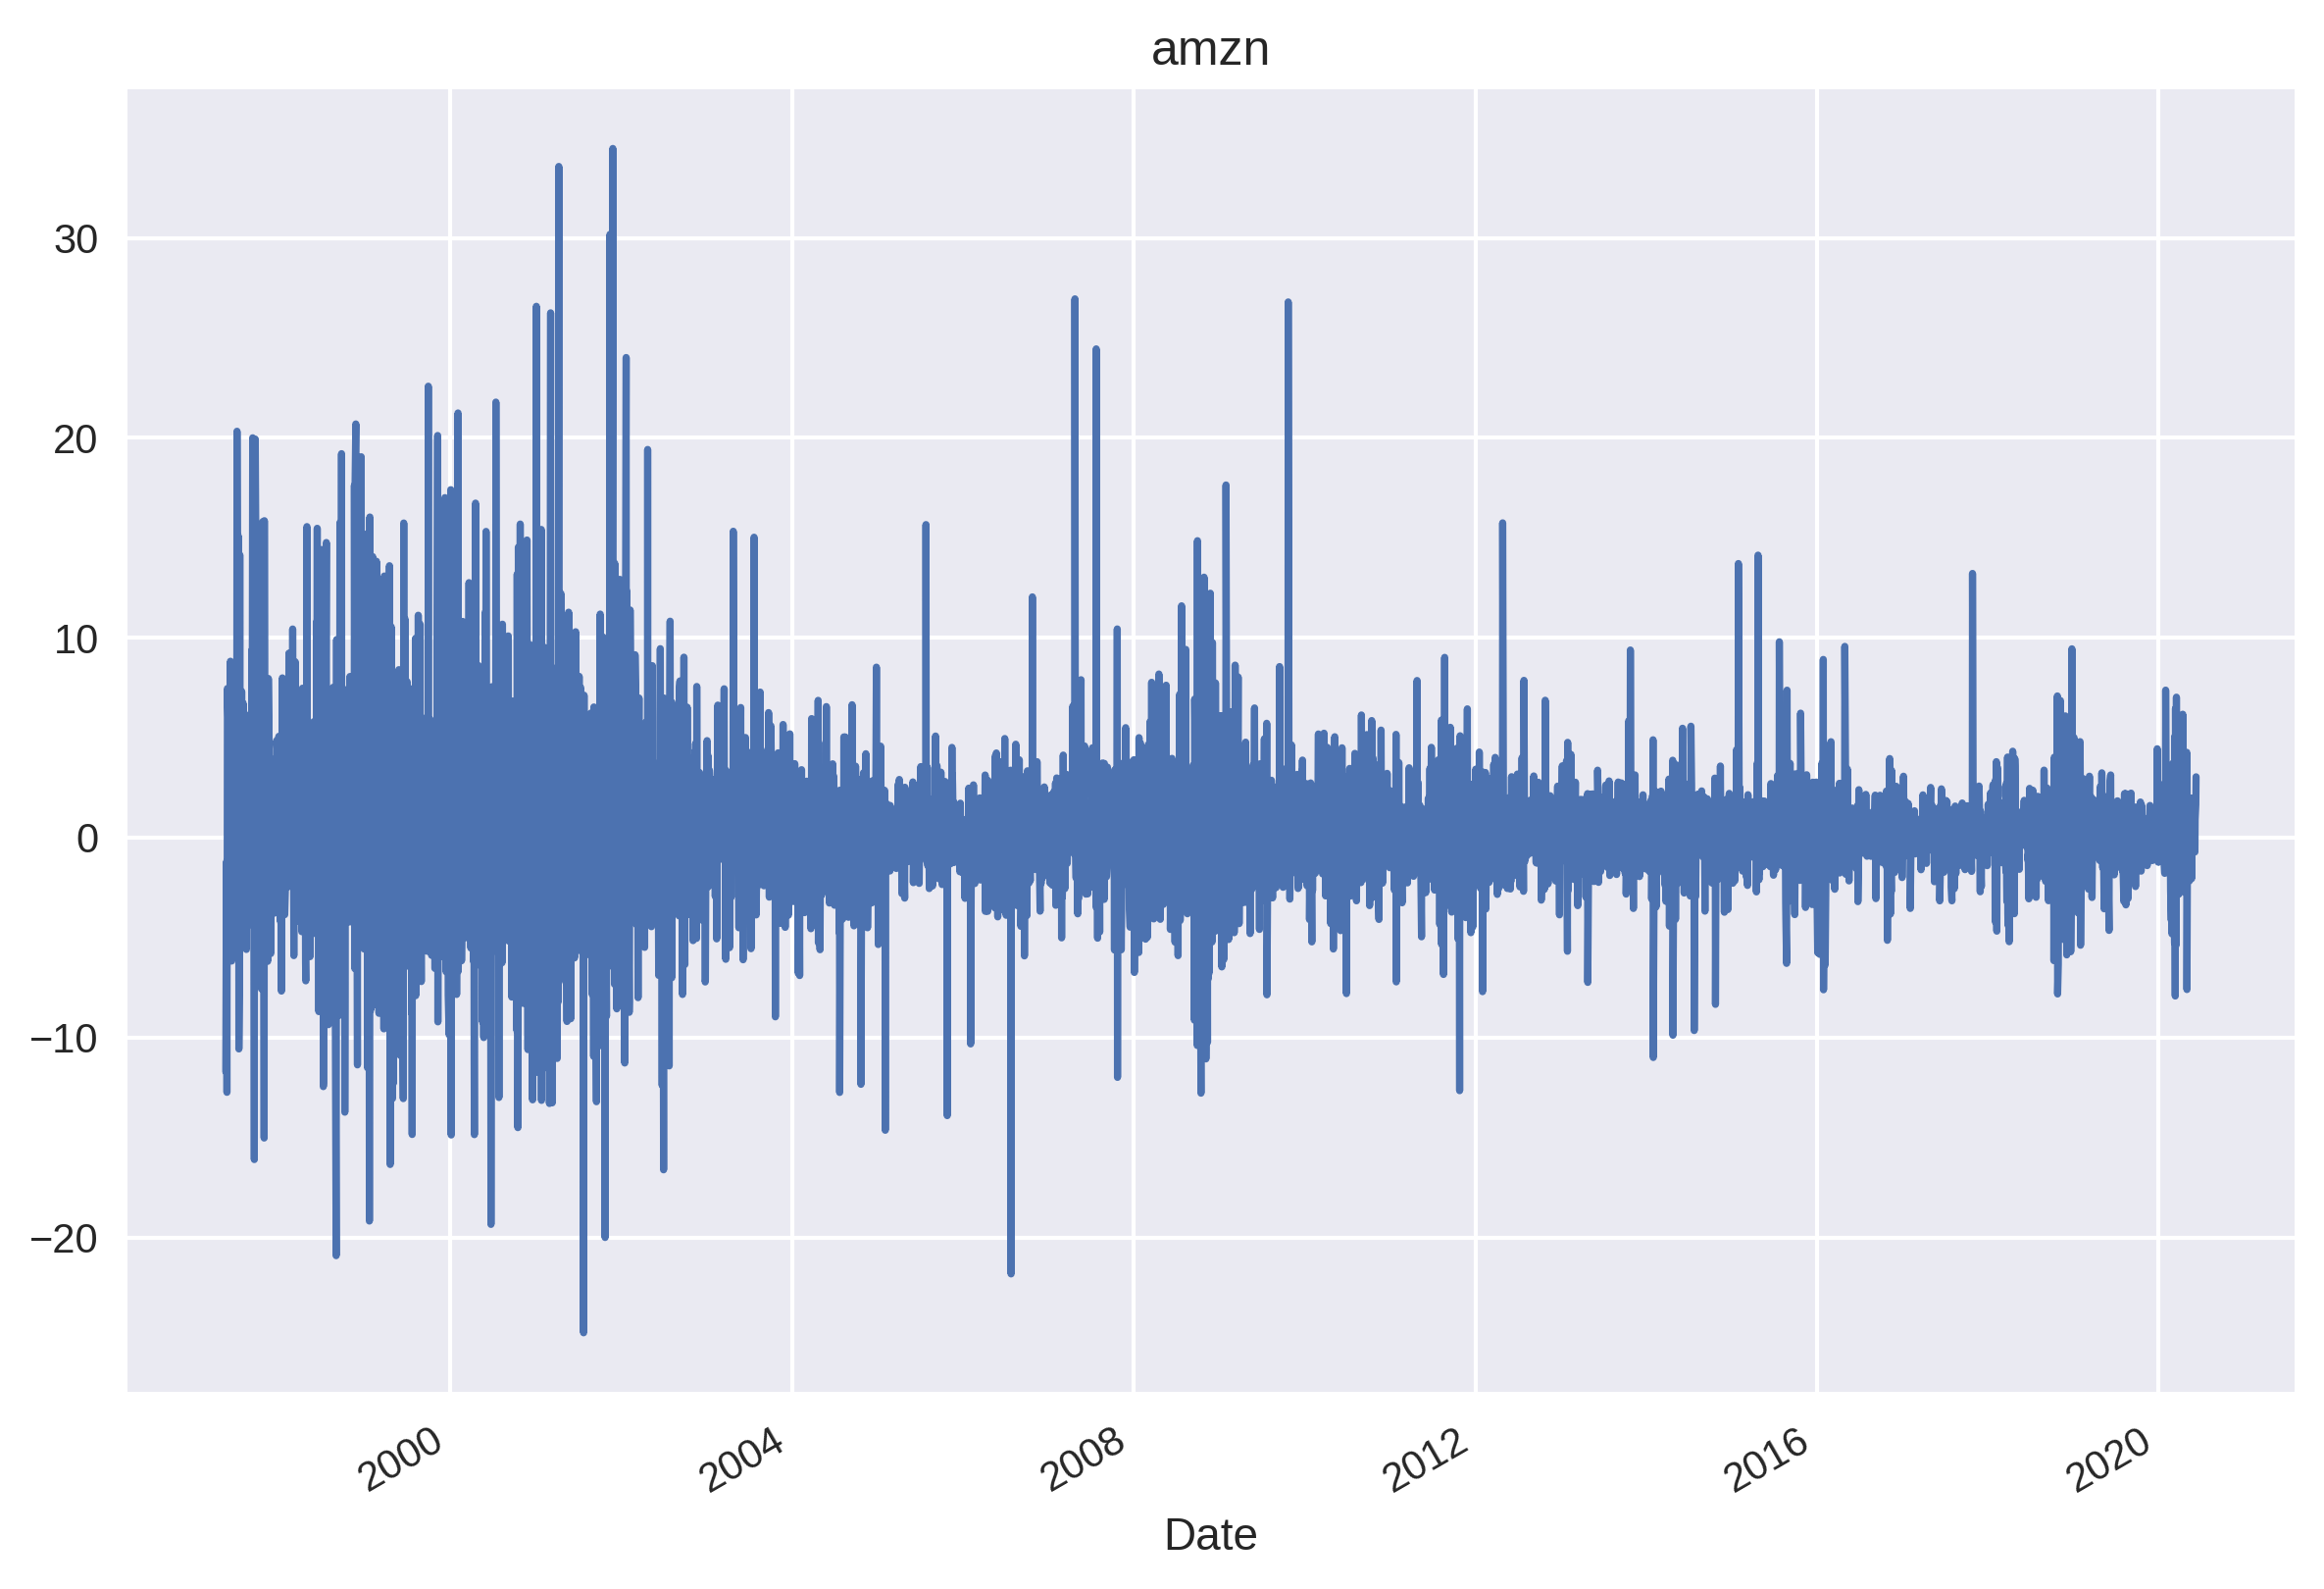

In [87]:
returns.name = 'asset_returns'
print(f'Average return: {round(returns.mean(), 2)}%')
returns.plot(title='amzn');

plt.tight_layout()
plt.show()

In [88]:
model = arch_model(returns, mean='Zero', vol='GARCH', 
                   p=1, o=0, q=1)

In [89]:
model_fitted = model.fit(disp='off')
print(model_fitted.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:          asset_returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -14560.8
Distribution:                  Normal   AIC:                           29127.6
Method:            Maximum Likelihood   BIC:                           29147.6
                                        No. Observations:                 5804
Date:                Tue, Jun 09 2020   Df Residuals:                     5801
Time:                        16:24:02   Df Model:                            3
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0158  1.055e-02      1.498      0.134 

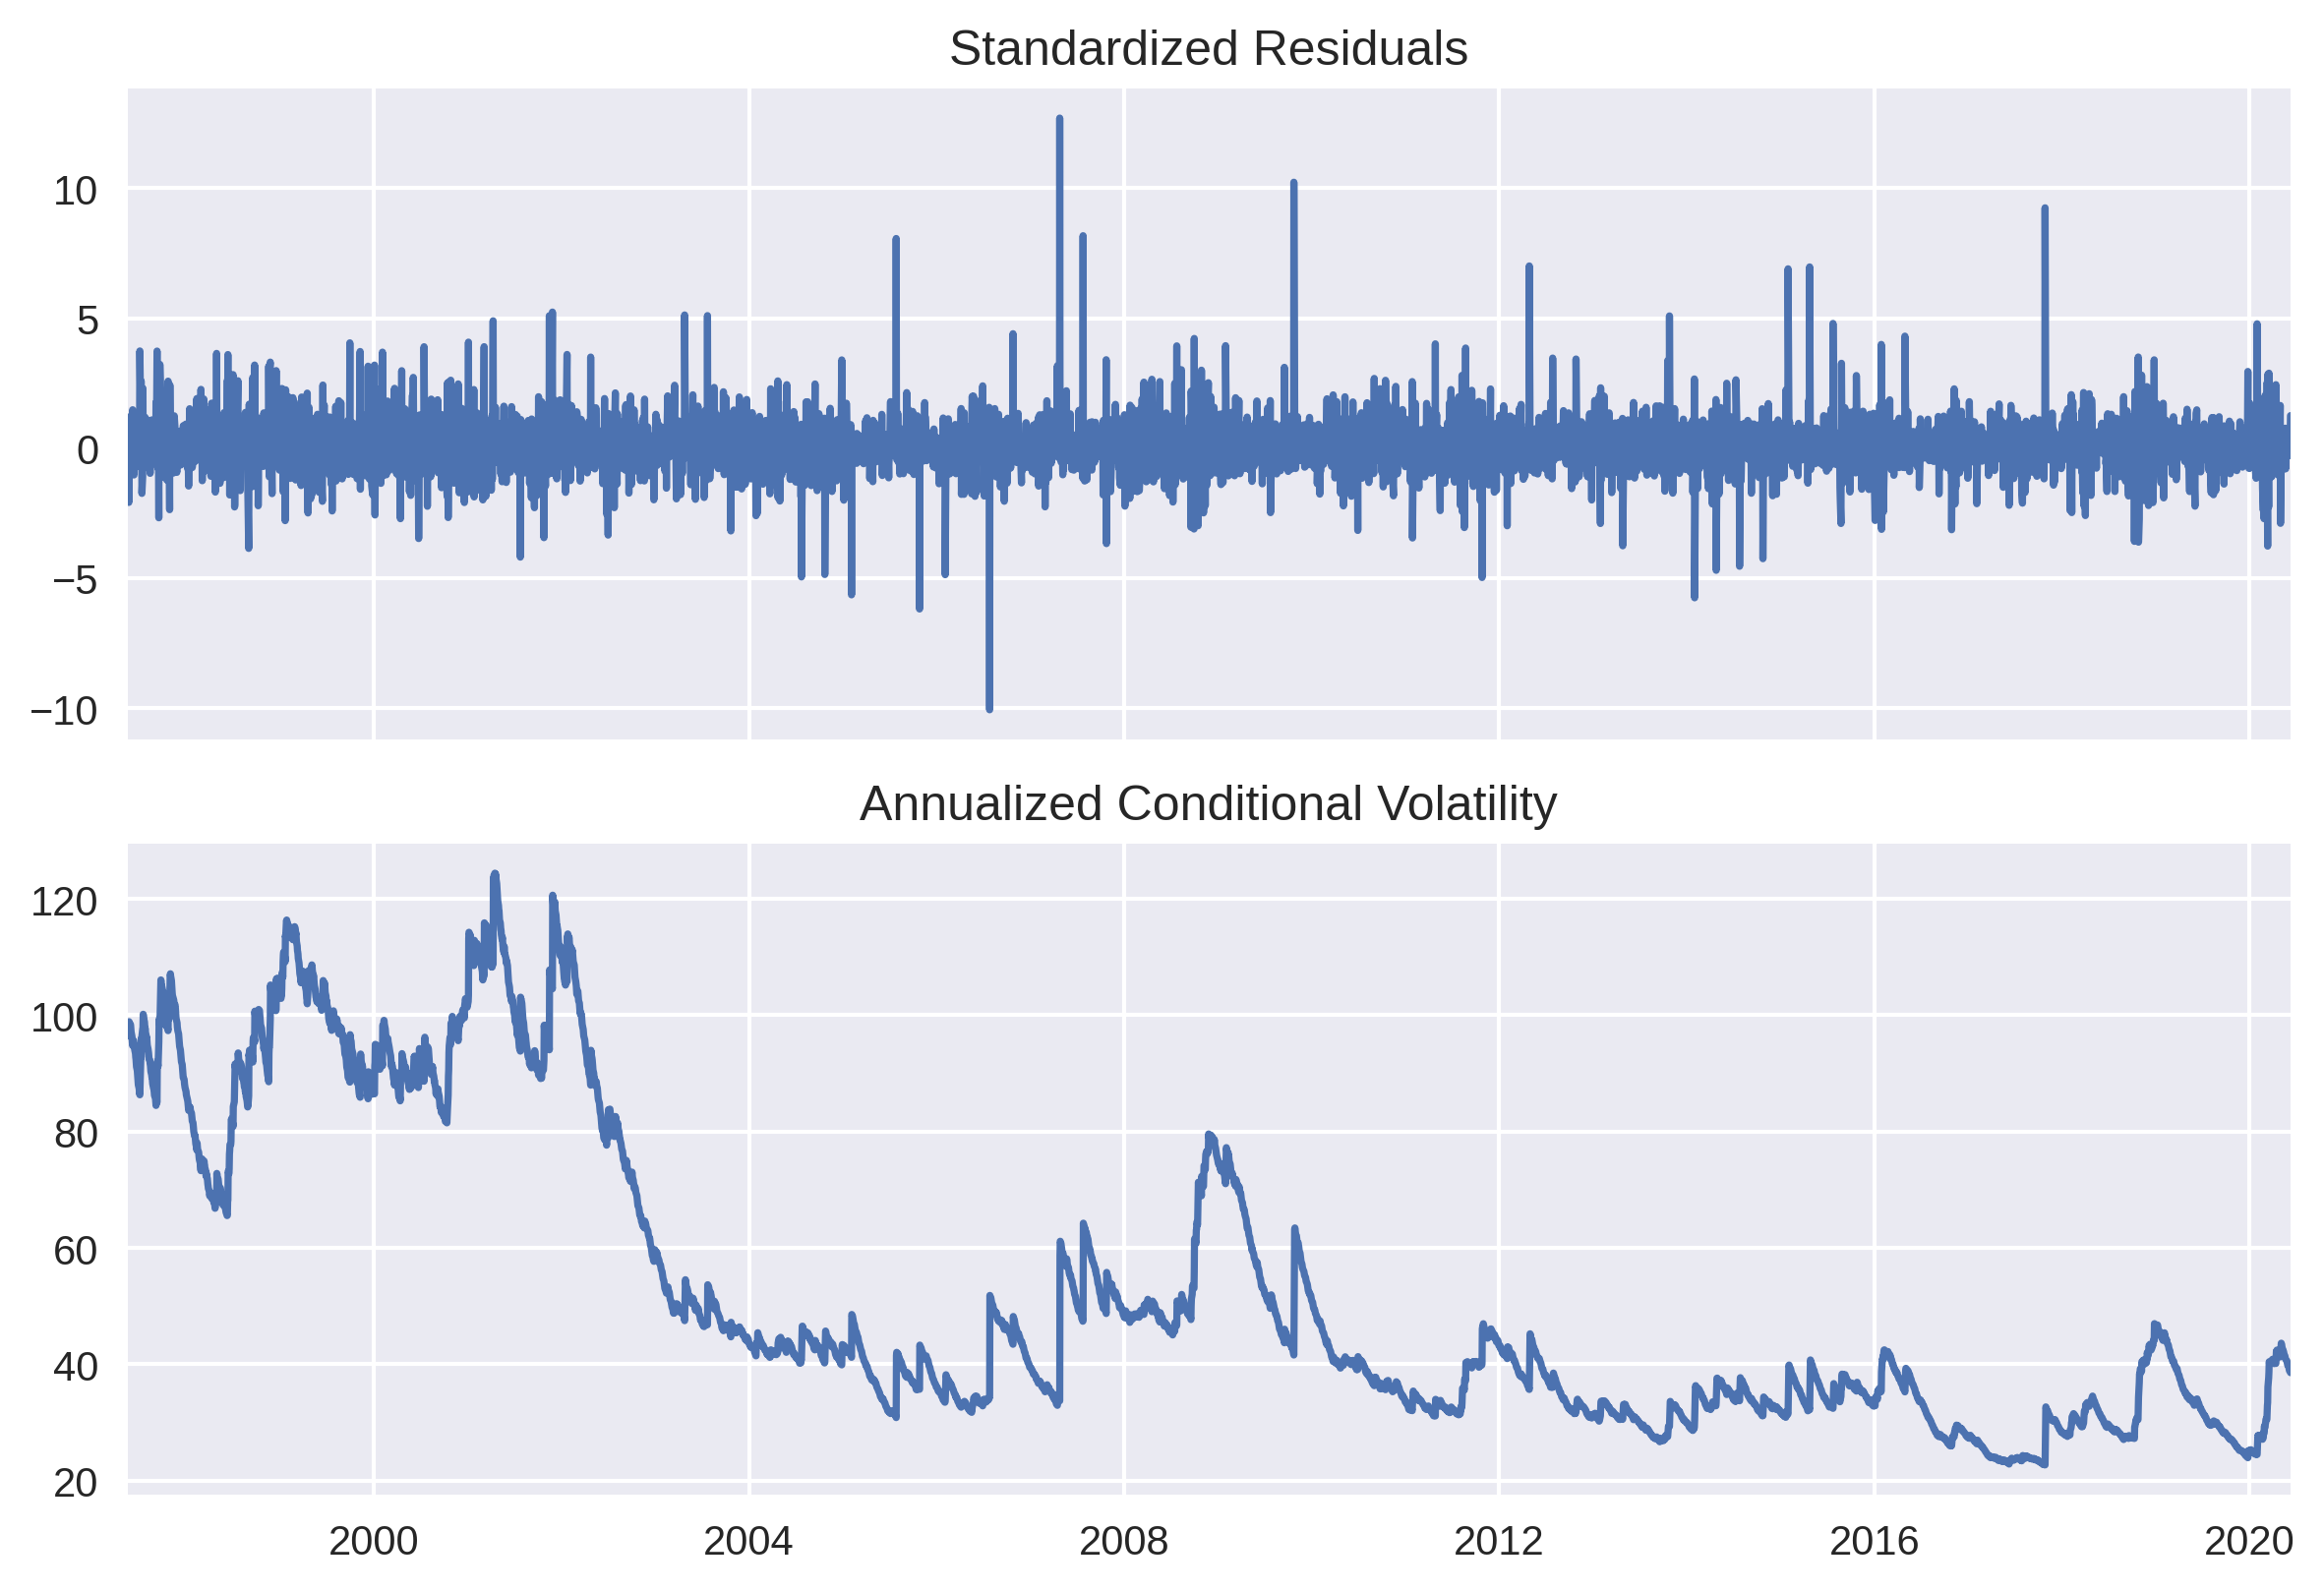

In [91]:
model_fitted.plot(annualize='D')

plt.tight_layout()
plt.show()